In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Implementando Convolução

Desenvolver em Python a operação de convolução Dw x Dw x C, com bias e função de ativação (ReLU e tanh), stride (inteiro positivo) e zero padding (boolean) especificados pelo usuário em tempo de execução. A máscara convolucional e o viés devem ser especificados em arquivo texto a ser lido durante a execução. Apresentar resultados com imagens RGB e em níveis de cinza, e com volumes Df x Df x N, produzidos a partir da aplicação prévia de N filtros convolucionais. Para visualização, os mapas de ativação devem ser convertidos para imagens em níveis de cinza no intervalo [0, 255], com a) níveis em valor absoluto com preto = zero; e b) mínimo = preto.  

### Parte 1 - Operação de Convolução

Uma operação de convolução, dada pela equação abaixo, pode ser realizada a partir da aplicação de uma máscara/filtro convolucional para cada pixel da imagem.  

\begin{align}
g[n] = \sum_{\tau=-\infty}^\infty s[\tau] h[n]-\tau]
\end{align}

Na equação, g é o resultado da operação, s o sinal de entrada e h a máscara convolucional. A Figura abaixo exemplifica a operação para um pixel em uma imagem de dimensão 8x8, utilizando máscara 3x3.

![title](imgs/conv.jpg)

Para realizar a operação em Python, duas funções deverão ser implementadas: zero_pad(X) e convolution(X, kernel, stride, padding), em que X é a imagem de entrada. Na função zero_pad(X), caso o usuário deseje realizar a operação de padding, a função deverá preencher a imagem de entrada com zeros, retornando a matriz X_pad. O método numpy.pad não deverá ser utilizado para realização dessa operação.

Na função convolution(X,kernel,stride,padding), implemente a operação de convolução propriamente dita utilizando apenas funçoes básicas da biblioteca Numpy (i.e. função convolve, convolve2d, pad e outras do Numpy não serão permitidas nesse exercício). A função retornará uma matriz out_conv e deverá ser testada com imagens RGB e em níveis de cinza, considerando quatro casos principais:

1: stride = 1 e padding True: adicione uma extensão por zeros na imagem e deslize a máscara a cada pixel da imagem;

2: stride = 1 e padding False: não utilize extensão por zeros e deslize a máscara a cada pixel da imagem;

3: stride > 1 e padding True: adicione uma extensão por zeros na imagem e deslize a máscara a cada S pixels da imagem, em que S é o valor do stride fornecido pelo usuário;

4: stride > 1 e padding False: não dicione uma extensão por zeros na imagem e deslize a máscara a cada S pixels da imagem, em que S é o valor do stride fornecido pelo usuário;

OBS: ao utilizar stride > 1 ou padding, poderá ser necessário tratar casos em que a operação ultrapasse a dimensão da imagem X. 

In [4]:
def zero_pad(X, xsize, ysize):
    """
    Função para adicionar extensão por zeros na imagem de entrada.
    Parametro: X - imagem de entrada
    Retorno: X_pad - imagem resultante da extensão por zeros. 
    """
    h = X.shape[0]
    w = X.shape[1]
    if len(X.shape) == 3:
        z = X.shape[2]
        X_pad = np.concatenate((np.array([[[0]*h]*xsize]*z).T,X), axis=1)
        X_pad = np.concatenate((X_pad,np.array([[[0]*h]*xsize]*z).T), axis=1)
        X_pad = np.concatenate((X_pad,np.array([np.array([[0]*(w+2*xsize)]*ysize).T]*z).T), axis=0)
        X_pad = np.concatenate((np.array([np.array([[0]*(w+2*xsize)]*ysize).T]*z).T,X_pad), axis=0)
    else:
        X_pad = np.concatenate(([[0]*w]*xsize,X), axis=0)
        X_pad = np.concatenate((X_pad,[[0]*w]*xsize), axis=0)
        X_pad = np.concatenate((X_pad,np.array([[0]*(h+2*xsize)]*ysize).T), axis=1)
        X_pad = np.concatenate((np.array([[0]*(h+2*xsize)]*ysize).T,X_pad), axis=1)
   
    return X_pad

In [5]:
def convolution(X,kernel,stride=1, padding=True):
    """
    Função para implementar a operação de convolução.
    Parametros: X - imagem de entrada
                kernel - matriz com o kernel a ser utilizado pela operação
                stride - tamanho do passo a ser utilizado (default 1)
                padding - flag para utilização de padding (default True)
    retorno out_conv: matriz resultante da operação de convolução
    """
    x = X.copy()
    rx = kernel.shape[0]//2
    ry = kernel.shape[1]//2
    if padding:
        x = zero_pad(x, rx, ry)
    if len(X.shape) == 3:
        out = [[np.sum(x[i-rx:i+rx+1, j-ry:j+ry+1]*(kernel*x.shape[2])) 
                for j in range(ry, x.shape[1]-ry, stride)] 
                   for i in range(rx, x.shape[0]-rx, stride)]
    else:
        out = [[np.sum(x[i-rx:i+rx+1, j-ry:j+ry+1]*(kernel)) 
                for j in range(ry, x.shape[1]-ry, stride)] 
                   for i in range(rx, x.shape[0]-rx, stride)]
        
    return out

### Parte 2 - Camada convolucional 

Uma vez implementada a função convolution, pode-se implementar uma camada convolucional por meio da função convLayer(X,C,act_func, kernel, stride, padding). Uma camada convolucional é ilustrada conforme Figura abaixo.

Na Figura, uma imagem de entrada 32x32x3 é utilizada com 6 máscaras 5x5x3. Para cada filtro individualmente, aplica-se o bias (offset) seguido pela aplicação da função de ativação para formar seis mapas de característica (feature maps) de dimensão 28x28x6 (32 - 4 por não utilizar padding e 6 igual a quantidade de máscaras dessa camada).

![title](imgs/convlayer.png)


Baseado nisso, para implementar a camada, deve-se seguir como passos principais:

1. Inicializar a matriz fmap: essa matriz pode ser criada utilizando numpy (e.g. np.zeros) e deverá conter a dimensão de saída do feature map (e.g. 28x28x6). Para calcular essa dimensão, utilize a equação abaixo, em que C é igual ao volume do feature map:
\begin{align}
n_H = (X_H - filter_H+2*padding)/stride+1\\
n_W = (X_W - filter_W+2*padding)/stride+1\\
n_C = C
\end{align}

2. Se padding for necessário, realizar a operação implementada pela função zero_pad(X);

3. Implementar função de ativação. As funções de ativação definem o intervalo de valores que a saída do neurônio poderá ter. Nsse Notebook, duas funções de ativação devem ser implementadas (ReLU e Tanh). As funçoes, suas respectivas saídas e gráfico deverão ser similares ao exposto abaixo: 

-> Retificadora (Relu): saída 0 caso entrada seja negativa e maior que 1 caso contrário
$$ \begin{equation}
  relu = max(0,x)
\end{equation} $$
![alt text](imgs/relu.png "Title")
-> Tangente Hiperbólica: saída entre [-1,1]
$$ \begin{equation}
  tanh = \frac{2}{(1+e^{-2*z})} - 1
\end{equation} $$
![alt text](imgs/tanh.png "Title")

4. Para cada filtro, produzir um feature map a partir da aplicação da convolução, adicionando-se um bias e utilizando a função de ativação implementada na etapa 3.

5. Visualizar o feature map convertendo-o para uma imagem em níveis de cinza no intervalo [0, 255], com a) níveis em valor absoluto com preto = zero; e b) mínimo = preto.



In [27]:
def activation_func(func_type, z):
    """
    Função que implementa as funções de ativação ReLU e Tanh
    Parãmetros: func_type - uma string que contém a função de ativação desejada
                z - matriz resultante da convolução e do bias.
    Retorna: feature map
    """
    ### Seu código aqui (~2 linhas)
    if func_type == 'relu':
        return np.fmax(0,z)
    elif func_type == 'tanh':
        return (2/(1 + np.exp(-2*z))) - 1

In [38]:
def visualize_fmap(X):
    """
    Função que convertendo-o para uma imagem em níveis de cinza no intervalo [0, 255], 
    com a) níveis em valor absoluto com preto = zero; e b) mínimo = preto.
    """
    x = X.copy()
    x = x - x.min()
    x = x*255/x.max()
    plt.imshow(x, 'gray')
    plt.show()

In [53]:
def convLayer(X,act_func, filters, bias, stride, padding):
    """
    Implementa a camada convolucional utilizando bias e função de ativação.
    Parametros: X - matriz de entrada
                C - quantidade de canais do feature map
                filters - filtros utilizados na camada
                stride - tamanho do passo a ser utilizado (default 1)
                padding - flag para utilização de padding (default True)
    Retorno: fmap - feature map de dimensão (n_W,n_H, C)
    """
    fmap = np.array([convolution(X,f,stride,padding) for f in filters])
    fmap = activation_func(act_func, fmap + np.array(bias))
    return fmap

### Parte 4 - Main

Para finalizar, utilize a função main para leitura dos filtros e bias obtidos a partir de um arquivo csv. O arquivo poderá ser lido a partir de métodos do numpy (e.g. genfromtxt e loadfromtxt). Uma vez que stride e padding deverão ser especificados pelo usuário, a função input do Numpy poderá ser utilizada para obter os valores. Por fim, a imagem de entrada poderá ser obtida por meio de métodos da biblioteca PIL (i.e. Image), OpenCV, entre outros.

In [58]:
def main():
    convFilters = [np.array([[-1, -2, -1],[0, 0, 0], [1, 2, 1]]),  np.array([[1/9, 1/9, 1/9],[1/9, 0, 2], [1/9, 1/9, 1/9]])]
    #stride = int(input("Entre com um valor inteiro positivo para o stride "))
    #padding = (input("Sua operaçao será feita com padding? True or False"))
    stride = 2
    padding = False
    bias = 0
    imageFile = np.asarray(Image.open("imgs/lena.bmp"))
    plt.imshow(imageFile) 
    plt.show()
    fmap = convLayer(imageFile,'relu', convFilters, bias, stride, padding)
    print(fmap.shape)
    for f in fmap:
        visualize_fmap(f)


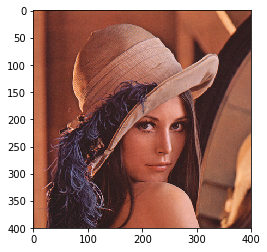

(2, 199, 199)


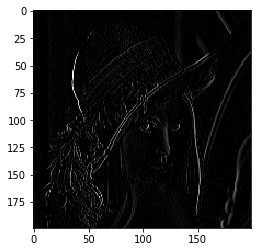

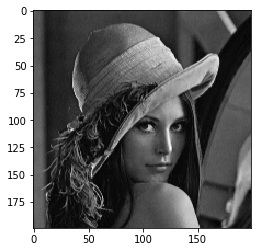

In [59]:
main()

(400, 400, 3)
(398, 398)
[[ 0.68273092  0.56894244  2.61713521 ...  2.16198126  0.34136546
   1.59303882]
 [ 1.47925033  1.70682731  0.79651941 ...  0.34136546  4.09638554
   0.79651941]
 [ 2.16198126  0.9103079   4.21017403 ...  0.11378849  7.73761714
   1.36546185]
 ...
 [23.44042838 13.65461847 13.54082999 ...  3.52744311  1.13788487
   1.70682731]
 [19.6854083  14.10977242 14.56492637 ...  2.50334672  1.59303882
   0.        ]
 [13.4270415  18.54752343 18.88888889 ...  4.66532798  1.47925033
   2.04819277]]


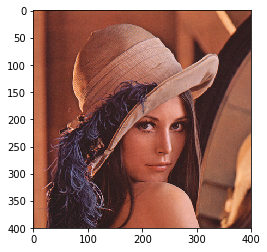

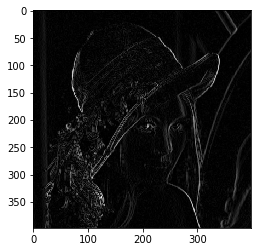

In [12]:
kernel = np.array([[-1, -2, -1],[0, 0, 0], [1, 2, 1]])
#rx = kernel.shape[0]//2
#ry = kernel.shape[1]//2
#i=j=1
imageFile = np.asarray(Image.open("imgs/lena.bmp"))
#print(rx,ry)
#print(imageFile[i-rx:i+rx+1, j-ry:j+ry+1]*(kernel*imageFile.shape[2]))
#print(np.sum(imageFile[i-rx:i+rx+1, j-ry:j+ry+1]*(kernel*imageFile.shape[2]), axis=(0,1)))
#plt.imshow(imageFile) 
print(imageFile.shape)
filterImg = np.array(convolution(imageFile, kernel,1,False))
print(filterImg.shape)
filterImg = np.abs(filterImg)
filterImg = filterImg*255/filterImg.max()
print(filterImg)
plt.imshow(imageFile)
plt.show()
plt.imshow(filterImg.astype('uint8'), 'gray') 